This demonstrates all the steps in my candidate selection before conducting visual inspection

In [1]:
import numpy as np
import splat
import wisps.data_analysis as wispd
from wisps.data_analysis import selection_criteria as sel_crt
import shapey
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import wisps

import matplotlib as mpl

from tqdm import tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline

Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database
Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database










In [2]:
#some functions 
def get_indices(x):
    if x is None :
        return pd.Series({})
    else:
        return  pd.concat([pd.Series(x.indices), pd.Series(x.mags), pd.Series(x.snr)])
    
def get_spt(x):
    if x is None:
        return np.nan
    else:
        return x.spectral_type[0]
#change f-test definition

def f_test_fx(x, df1, df2):
    return stats.f.cdf(x, df1, df2)

def box_parameters(idx, spt_range):
    bs=idx.shapes
    b=[x for x in bs if x.shape_name==spt_range][0]
    print ('{}  {} m: {} b: {} s:{}, comp : {}, cont: {}'.format(spt_range, idx,  round(b.coeffs[0], 2), round(b.coeffs[1], 2), round(b.scatter, 2), round(idx.completeness[spt_range], 2),  round(idx.contamination[spt_range], 3)))

In [3]:
#get data.big_file()
alldata=wisps.get_big_file()
spex=wisps.Annotator.reformat_table(wisps.datasets['spex'])

#cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf')
cands0=pd.read_hdf(wisps.LIBRARIES+'/objects_of_interest.h5', key='all')
cands0=(cands0[~cands0.spectra.isna()]).reset_index(drop=True)
cands=cands0.spectra.apply(get_indices)
cands['dof']=cands0.spectra.apply(lambda x: x.dof).values
cands['grism_id']=cands0.grism_id
cands['spt']=cands0.spectra.apply(get_spt)
cands['line_chi']=cands0.spectra.apply(lambda x : x.line_chi)
cands['spex_chi']=cands0.spectra.apply(lambda x: x.spex_chi)

#cands_dff['f_test']=(cands_dff['spex_chi']/cands_dff['line_chi']).apply(f_test_fx)

cands=wisps.Annotator.reformat_table(cands)
cands=cands[(cands.spt >=17.) ]
cands=cands.reset_index(drop=True)



spex_df=wisps.Annotator.reformat_table(wisps.datasets['spex']).reset_index(drop=True)
manj=wisps.Annotator.reformat_table(wisps.datasets['manjavacas']).reset_index(drop=True)
schn=wisps.Annotator.reformat_table(wisps.datasets['schneider']).reset_index(drop=True)
ydwarfs=(manj[manj['spt'].apply(wisps.make_spt_number)>38].append(schn)).reset_index(drop=True)
spex_df['spt']=np.vstack(spex_df['spt'].values)[:,0]
manj['spt']=np.vstack(manj['spt'].values)[:,0]
schn['spt']=np.vstack(schn['spt'].values)[:,0]

cands.grism_id=cands.grism_id.apply(lambda x: x.lower())

cands['spt']=np.vstack(cands['spt'].values)
                           

In [4]:
cands_aug=cands.merge(alldata, on='grism_id')

In [5]:
spex['x']=spex.spex_chi/spex.line_chi
alldata['x']=alldata.spex_chi/alldata.line_chi
#ydwarfs['x']=ydwarfs.spex_chi/ydwarfs.line_chi
cands['x']=cands.spex_chi/cands.line_chi


cands['f_test']=f_test_fx(cands.x, cands_aug.nG141-2, cands_aug.nG141-2)
spex['f_test']=f_test_fx(spex.x, spex.dof-2, spex.dof-2)
alldata['f_test']=f_test_fx(alldata.x, alldata.nG141-2, alldata.nG141-2)

alldata=alldata.sort_values('x')
spex=spex.sort_values('x')
cands=cands.sort_values('x')


Text(0.5, 0, 'SPEX-CHISQUARED/LINE-CHISQUARED')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


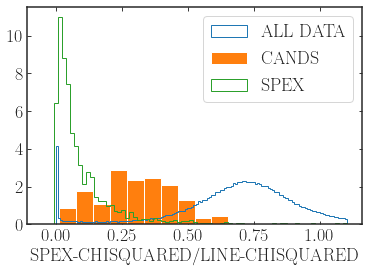

In [6]:
h2=plt.hist(alldata.x, range=[-0.05, 1.1], density=True, bins='auto', histtype='step', label='ALL DATA')
h3=plt.hist(cands.x, range=[-.05, 1.1], density=True, bins='auto', label='CANDS')
h=plt.hist(spex.x, range=[-.05, 1.1], density=True, bins='auto', histtype='step', label='SPEX')
plt.legend()
plt.xlabel('SPEX-CHISQUARED/LINE-CHISQUARED', fontsize=18)

#### 

(0.0, 5.0)

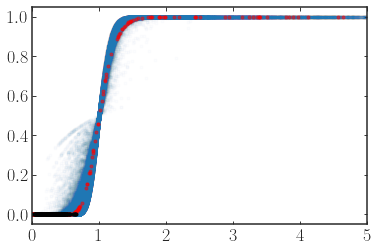

In [7]:
plt.plot(alldata.x, alldata.f_test, '.', alpha=0.01)
plt.plot(spex.x, spex.f_test, '.', c='r', alpha=0.5)
plt.plot(cands.x, cands.f_test, '.', c='k')

plt.xlim([0, 5])

(-0.1, 1.0)

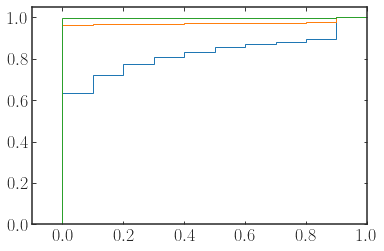

In [8]:
h=plt.hist(alldata.f_test, cumulative=True, density=True, histtype='step')
h=plt.hist(spex.f_test, cumulative=True, density=True, histtype='step')
h=plt.hist(cands.f_test, cumulative=True, density=True, histtype='step')
#plt.plot(cands.x, cands.f_test, '.', c='k')

plt.xlim([-0.1, 1])

In [9]:
len(spex[np.logical_and(spex.f_test.values > 0.9, np.vstack(spex.spt.values)[:,0] >=17.)])/len(spex)

0.012860483242400623

In [10]:
len(spex[np.logical_and(spex.f_test.values < 0.5, np.vstack(spex.spt.values)[:,0] >=17.)])/len(spex)

0.8016367887763055

In [11]:
len(cands[np.logical_and(cands.f_test.values > 0.9, np.vstack(cands.spt.values)[:,0] >=17.)])/len(cands)

0.005376344086021506

In [12]:
len(cands[np.logical_and(cands.f_test.values < 0.5, np.vstack(cands.spt.values)[:,0] >=17.)])/len(cands)

0.9946236559139785

In [13]:
#star_ids=alldata[alldata['class_star'] !=0]
#stars=wisps.Annotator.reformat_table(star_ids).reset_index(drop=True)
#cy=stars[stars.grism_id.isin(cx.grism_id)]

In [14]:
spex.x.mean()

0.2020271404411347

In [15]:
dt=alldata[(alldata.f_test<0.02) & (alldata.x <0.5) & (alldata.snr1>=3.) &  (alldata.mstar_flag !=0)].reset_index(drop=True)
dt['spt']=(dt['spt']).apply(wisps.make_spt_number).apply(float)

In [16]:
dt=wisps.Annotator.reformat_table(dt).reset_index(drop=True)

In [17]:
#get criteria 
##only run this if new data
gbhio=sel_crt.save_criteria(conts=dt)
crts=sel_crt.crts_from_file()
contamns=pd.DataFrame([ x.contamination for x in crts.values()])
compls=pd.DataFrame([ x.completeness for x in crts.values()])

contamns.index=[x for x in crts.keys()]
compls.index=[x for x in crts.keys()]

  0%|          | 0/120 [00:00<?, ?it/s]

(2452, 34) (113, 34)


100%|██████████| 120/120 [00:38<00:00,  3.14it/s]


In [18]:
%%capture
'''
contamns.style.apply(lambda x: ["background-color: #7FDBFF" 
                          if (i >= 0 and (v < 0.1 
                                          and v > 0. )) 
                          else "" for i, v in enumerate(x)], axis = 1)
'''

In [19]:
def get_toplowest_contam(subtype, n):
    top=contamns.sort_values('L5-T0')[:n]
    return {subtype: [x  for x in top.index]}

In [20]:
ordered={}
for k in ['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-T9', 'Y dwarfs', 'subdwarfs']:
    ordered.update(get_toplowest_contam(k, 6))

In [21]:
to_use= ordered


In [22]:
spex['spt']=np.vstack(spex.spt.values)[:,0]

In [23]:
from tqdm import tqdm

In [24]:
def multiplte_indices_selection(k):
    stat_dict={}
    indices= [crts[index_name] for index_name in to_use[k]]
    #make selections for each index separately
    cand_bools=[]
    spex_bools=[]
    trash_bools=[]
    for idx in indices:
        xkey=idx.xkey
        ykey=idx.ykey
        bx=[x for x in idx.shapes if x.shape_name==k][0]
        _, cbools=bx._select(np.array([cands[xkey].values,cands[ykey].values]))
        _, spbools=bx._select(np.array([spex[xkey].values,spex[ykey].values]))
        _, trbools=bx._select(np.array([dt[xkey].values, dt[ykey].values]))
        
        cand_bools.append(cbools)
        spex_bools.append(spbools)
        trash_bools.append(trbools)
        
    cands_in_that_class_bool=cands.spt.apply(lambda x: wisps.is_in_that_classification(x, k))
    spex_in_that_class_bool=spex.spt.apply(lambda x: wisps.is_in_that_classification(x, k))

    cand_bools.append(cands_in_that_class_bool)
    spex_bools.append(spex_in_that_class_bool)
    
    cands_selected=cands[np.logical_and.reduce(cand_bools, axis=0)]
    spexs_selected=spex[np.logical_and.reduce(spex_bools, axis=0)]
    
    print (' {} selected {} out of {} UCDS'.format(k, len( cands_selected), len(cands[cands_in_that_class_bool])))
    print ('overall completeness {}'.format( len(spexs_selected)/len(spex[spex_in_that_class_bool])))
    print ('total contaminants {}'.format(len(dt[np.logical_and.reduce(trash_bools)])))
    print ('-------------------------------------------')

In [25]:
for k in ['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-T9', 'Y dwarfs']:
    multiplte_indices_selection(k)

 M7-L0 selected 70 out of 146 UCDS
overall completeness 0.9263873159682899
total contaminants 242
-------------------------------------------
 L0-L5 selected 10 out of 26 UCDS
overall completeness 0.9371069182389937
total contaminants 14
-------------------------------------------
 L5-T0 selected 3 out of 8 UCDS
overall completeness 0.9328537170263789
total contaminants 10
-------------------------------------------
 T0-T5 selected 1 out of 9 UCDS
overall completeness 0.8974358974358975
total contaminants 6
-------------------------------------------
 T5-T9 selected 2 out of 4 UCDS
overall completeness 0.8403361344537815
total contaminants 3
-------------------------------------------
 Y dwarfs selected 1 out of 1 UCDS
overall completeness 0.2857142857142857
total contaminants 1
-------------------------------------------


In [26]:
contamns.idxmin(axis=0)

L0-L5          H_2O-1/J-Cont H_2O-2+CH_4/H-Cont
L5-T0        H_2O-1/J-Cont H_2O-1+H_2O-2/H-Cont
M7-L0          H_2O-1/J-Cont H_2O-2+CH_4/H-Cont
T0-T5               H_2O-1/J-Cont H_2O-2/H_2O-1
T5-T9        H_2O-2/H_2O-1 H_2O-1+H_2O-2/J-Cont
subdwarfs             H_2O-1/J-Cont CH_4/J-Cont
trash                 H_2O-1/J-Cont CH_4/H-Cont
Y dwarfs            H_2O-1/J-Cont H_2O-2/H_2O-1
dtype: object

In [27]:
from collections import OrderedDict
ordered=[(k, contamns.idxmin(axis=0)[k]) for k in ['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-T9', 'Y dwarfs', 'subdwarfs']]
to_use=  [ (y, x) for x, y in ordered]

In [28]:
to_use

[('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'M7-L0'),
 ('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'L0-L5'),
 ('H_2O-1/J-Cont H_2O-1+H_2O-2/H-Cont', 'L5-T0'),
 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'T0-T5'),
 ('H_2O-2/H_2O-1 H_2O-1+H_2O-2/J-Cont', 'T5-T9'),
 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'Y dwarfs'),
 ('H_2O-1/J-Cont CH_4/J-Cont', 'subdwarfs')]

In [29]:
import pickle
#save the random forest
output_file=wisps.OUTPUT_FILES+'/best_indices_to_use.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(to_use,file)

In [30]:
fp={}

In [31]:
cands=cands[cands.grism_id.isin(dt.grism_id)]

In [32]:
def plot_index_box(index_name, box_name, ax):
    
    #get the index and the box
    idx=crts[index_name]
    bx=[x for x in idx.shapes if x.shape_name==box_name][0]
    
    xkey=idx.xkey
    ykey=idx.ykey

    to_use_df=spex_df
    if box_name.lower()=='y dwarfs':
        to_use_df=ydwarfs
    if box_name.lower()=='subdwarfs':
        to_use_df=wisps.Annotator.reformat_table(idx.subdwarfs)
        to_use_df['spt']=17
        
    xlim=[ bx.xrange[0]-.5*abs(np.ptp(bx.xrange)), bx.xrange[1]+.5*abs(np.ptp(bx.xrange))]
    ylim=[ bx.yrange[0]-.5*abs(np.ptp(bx.yrange)), bx.yrange[1]+.5*abs(np.ptp(bx.yrange))]
    
    if box_name.upper()=='T5-T9':
        print ('changin scale')
        print (bx.xrange[1])
        xlim=[ bx.xrange[0]-0.2*abs(np.ptp(bx.xrange)), np.round(bx.xrange[1]+0.2*abs(np.ptp(bx.xrange)))]

    
    #remove nans from background
    bckgrd= dt[[xkey, ykey]].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna()
    ax.scatter(bckgrd[xkey], bckgrd[ykey], s=1, c='#111111', label='Background')
    
    #bckgrd=bckgrd[(bckgrd[xkey].between(xlim[0], xlim[1])) & (bckgrd[ykey].between(ylim[0], ylim[1]))]

    #h=ax.hist2d(bckgrd[xkey].apply(float).values, bckgrd[ykey].apply(float).values, cmap='gist_yarg')
    
    cands_slctd, cands_bools=bx._select(np.array([cands[xkey].values,cands[ykey].values]))
   
    trash_slctd, trsh_bools=bx._select(np.array([dt[xkey].values, dt[ykey].values]))
    
    #simul_slctd, simul_bools=bx._select(np.array([simulated_data[xkey].values, simulated_data[ykey].values]))
    
    
    cands_in_that_class_bool=(cands[ cands_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    spexs_slctd_in_that_class_bool= (to_use_df).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    #simulated_in_that_class_bool=(simulated_data[simul_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    if box_name.lower()=='subdwarfs':
         spexs_slctd_in_that_class_bool=np.ones(len(to_use_df), dtype=bool)
    
    
    
    
    cands_in_that_class=np.array([cands_slctd[0][cands_in_that_class_bool], cands_slctd[1][cands_in_that_class_bool]])
    
    #simulated_in_that_class= np.array([simul_slctd[0][simulated_in_that_class_bool], simul_slctd[1][simulated_in_that_class_bool]])
    
    spexs_slctd_in_that_class=np.array([to_use_df[xkey][spexs_slctd_in_that_class_bool], to_use_df[ykey][spexs_slctd_in_that_class_bool]])
    

    #ax.scatter( simulated_in_that_class[0],    simulated_in_that_class[1], facecolors='none', s=10, 
    #           edgecolors='#001f3f', label='simulated')
    
    ax.scatter(spexs_slctd_in_that_class[0], spexs_slctd_in_that_class[1],  facecolors='none', edgecolors='#111111',  
           label='Templates {}'.format(box_name), s=50.)

    #ax.scatter(cands[xkey], cands[ykey], marker='x', facecolors='#FF851B', s=40., alpha=0.5)
    
    
    ax.scatter( cands_in_that_class[0],    cands_in_that_class[1], marker='*', facecolors='#0074D9', edgecolors='#0074D9', 
           s=150., alpha=1., label='Discovered {}'.format(box_name))
    
    
    
    bx.color='None'
    bx.alpha=1.
    bx.linewidth=3
    bx.linestyle='-'
    bx.edgecolor='#0074D9'
    bx.plot(ax=ax, only_shape=True, highlight=False)
    
    #cb = plt.colorbar(h[3], ax=ax, orientation='horizontal')
    #cb.set_label('Counts in bin', fontsize=16)
    
    plt.tight_layout()
    
    ax.set_xlabel(r'$'+str(idx.name.split(' ')[0])+'$', fontsize=14)
    ax.set_ylabel(r'$'+str(idx.name.split(' ')[1])+'$', fontsize=14)
    
    ax.set_title(box_name, fontsize=18)
    
    xbuffer=np.nanstd(to_use_df[[xkey,ykey]])
    
   
    
    ax.minorticks_on()
    

    if (trash_slctd.shape[1])==0:
        fprate=0.0
    else:
        fprate=(trash_slctd.shape[1]- cands_slctd.shape[1])/trash_slctd.shape[1]
        if box_name.lower()=='subdwarfs':
                fprate=1.
    
    fp[box_name]=  fprate
    
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    plt.tight_layout()
    print (' {} selected {}'.format(box_name, len(bx.select( bckgrd))))
    
    return {str(box_name): bx}
    
    

In [33]:
to_use

[('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'M7-L0'),
 ('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'L0-L5'),
 ('H_2O-1/J-Cont H_2O-1+H_2O-2/H-Cont', 'L5-T0'),
 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'T0-T5'),
 ('H_2O-2/H_2O-1 H_2O-1+H_2O-2/J-Cont', 'T5-T9'),
 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'Y dwarfs'),
 ('H_2O-1/J-Cont CH_4/J-Cont', 'subdwarfs')]

In [83]:
idx=crts[to_use[1][0]]

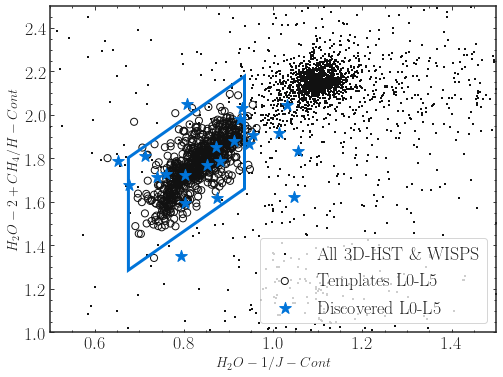

In [84]:
#plt.style.use('dark_background')

fig, ax=plt.subplots(figsize=(8, 6))

xkey=idx.xkey
ykey=idx.ykey

to_use_df=spex_df
box_name='L0-L5'
bx=[x for x in idx.shapes if x.shape_name=='L0-L5'][0]

bckgrd= dt[[xkey, ykey]].replace(-np.inf, np.nan).replace(np.inf, np.nan).dropna()
cands_slctd, cands_bools=bx._select(np.array([cands[xkey].values,cands[ykey].values]))

plt.scatter(bckgrd[xkey], bckgrd[ykey], s=2, marker='+', c='#111111', label='All 3D-HST \& WISPS')
  
spexs_slctd_in_that_class_bool= (to_use_df).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
spexs_slctd_in_that_class=np.array([to_use_df[xkey][spexs_slctd_in_that_class_bool], to_use_df[ykey][spexs_slctd_in_that_class_bool]])

ax.scatter(spexs_slctd_in_that_class[0], spexs_slctd_in_that_class[1],  facecolors='none', edgecolors='#111111',  
           label='Templates L0-L5', s=50.)


ldfs =cands[cands.spt.between(20, 25)]
odfs =cands[~cands.spt.between(20, 25)]
#ax.scatter(odfs[xkey], odfs[ykey], marker='x', facecolors='#FF851B', s=150., alpha=0.5, label='Candidates')
ax.scatter(ldfs[xkey], ldfs[ykey], marker='*', facecolors='#0074D9', edgecolors='#0074D9', 
           s=150., alpha=1., label='Discovered L0-L5')

bx.color='None'
bx.alpha=1.
bx.linewidth=3
bx.linestyle='-'
bx.edgecolor='#0074D9'
bx.plot(ax=ax, only_shape=True, highlight=False)

plt.xlim([0.5, 1.5])
plt.ylim([1., 2.5])
plt.minorticks_on()

ax.set_xlabel(r'$'+str(idx.name.split(' ')[0])+'$', fontsize=14)
ax.set_ylabel(r'$'+str(idx.name.split(' ')[1])+'$', fontsize=14)

plt.legend(loc='lower right')
#ax.scatter( cands_in_that_class[0],    cands_in_that_class[1], marker='x', facecolors='#FF851B', s=40, 
#           edgecolors='#FF4136', label='candidates')
#plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+ '/example_index_plot.pdf',  bbox_inches='tight',  facecolor='white', transparent=False)

In [36]:
#hjk

0 ('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'M7-L0')
 M7-L0 selected 332
1 ('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'L0-L5')
 L0-L5 selected 51
2 ('H_2O-1/J-Cont H_2O-1+H_2O-2/H-Cont', 'L5-T0')
 L5-T0 selected 39
3 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'T0-T5')
 T0-T5 selected 13
4 ('H_2O-2/H_2O-1 H_2O-1+H_2O-2/J-Cont', 'T5-T9')
changin scale
0.6599363469509804
 T5-T9 selected 2
5 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'Y dwarfs')
 Y dwarfs selected 0
6 ('H_2O-1/J-Cont CH_4/J-Cont', 'subdwarfs')
 subdwarfs selected 1059


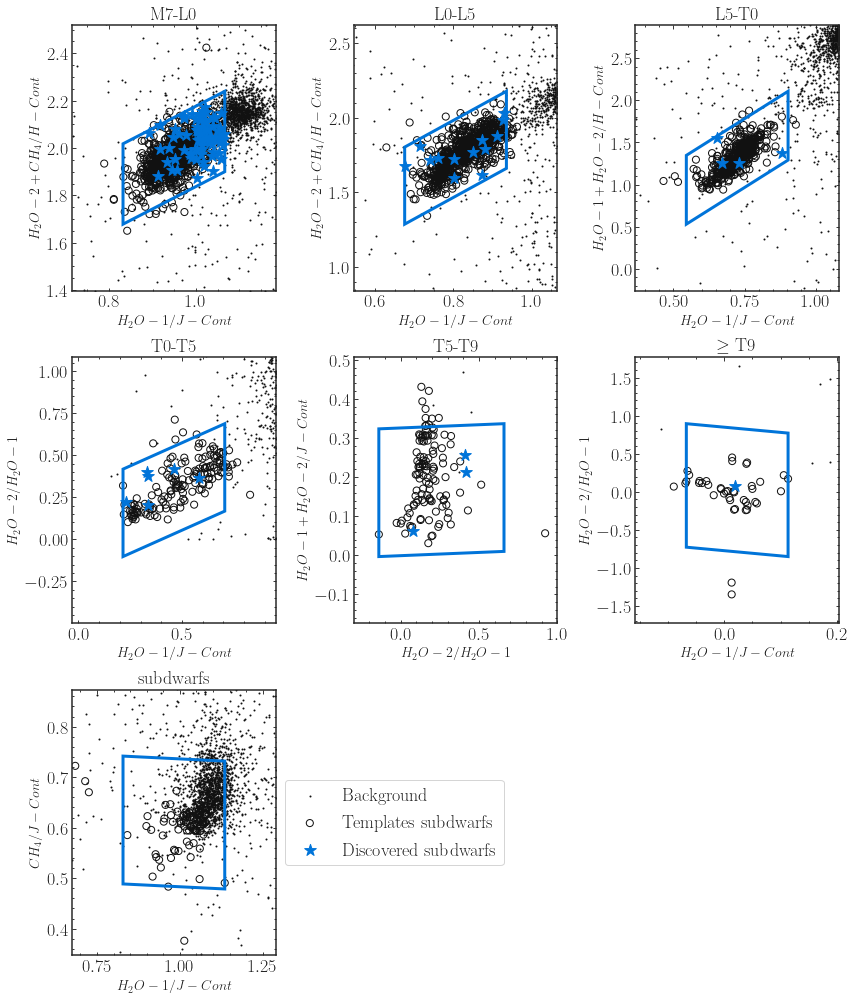

In [37]:
fig, ax=plt.subplots(nrows=3, ncols=3, figsize=(12, 14))

bxs=[]
for idx, k in enumerate(to_use):
    print (idx, k)
    b=plot_index_box( k[0], k[1], np.concatenate(ax)[idx])
    bxs.append(b)



plt.tight_layout()


fig.delaxes(np.concatenate(ax)[-1])
fig.delaxes(np.concatenate(ax)[-2])



np.concatenate(ax)[-4].set_title(r'$\geq$ T9 ', fontsize=18)
#subdindx_index_crt=crts['H_2O-1/J-Cont H_2O-2/H_2O-1']
#subdrfs=wisps.Annotator.reformat_table(dummy_index_crt.subdwarfs)
#tpls=wisps.Annotator.reformat_table(spex_df[spex_df.metallicity_class.isna()])
#a=np.concatenate(ax)[-1]
#tpls=tpls[tpls.spt>16]

#a.scatter(dt[subdindx_index_crt.xkey], dt[subdindx_index_crt.ykey], s=1., c='#111111', alpha=0.1)
#a.scatter(tpls[subdindx_index_crt.xkey], tpls[subdindx_index_crt.ykey], marker='+', facecolors='#0074D9',  label='SpeX', s=5.)
#a.scatter(subdrfs[subdindx_index_crt.xkey], subdrfs[subdindx_index_crt.ykey], marker='+', facecolors='#2ECC40',  label='SpeX', s=30.)


#a.set_xlim([0., 1.35])
#a.set_ylim([0., 1.25])
#a.set_title('subdwarfs', fontsize=18)
#a.set_xlabel(r'$'+str(subdindx_index_crt.name.split(' ')[0])+'$', fontsize=15)
#a.set_ylabel(r'$'+str(subdindx_index_crt.name.split(' ')[1])+'$', fontsize=15)

np.concatenate(ax)[-3].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig(wisps.OUTPUT_FIGURES+'/index_index_plots.pdf', bbox_inches='tight', rasterized=True,  dpi=50000)

In [38]:
from tensorflow import keras

rfdict=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier.pkl') #the classifier 
neural_network= keras.models.load_model(wisps.OUTPUT_FILES+'/deep_model_september23.h5')
features=rfdict['feats']

probs= neural_network.predict(alldata[features])
labels=np.logical_or.reduce((probs[:, 2] >.95, probs[:,3] >.95 , probs[:,4] >0.8))
sltc=cands[cands.grism_id.str.lower().isin((alldata[labels]).reset_index(drop=True).grism_id.values)]

In [39]:
common=dt[dt.grism_id.isin(cands.grism_id)]

In [40]:
len(sltc)

145

In [41]:
#.grism_id.to_csv('/users/caganze/desktop/true_brown_dwarfs.csv')

In [42]:
bx_dict={}
for b in bxs:
    bx_dict.update(b)

In [43]:
#invert to use
inv_to_use = {v: k for k, v in to_use}

In [44]:
ncandidates=[]
for spt_range in bx_dict.keys():
    idx_name=inv_to_use[spt_range]
    idx=crts[idx_name]
    s, bools=(bx_dict[spt_range])._select(np.array([dt[idx.xkey].values, dt[idx.ykey].values]))
    ncandidates.append(dt[bools])

In [45]:
candsss=(pd.concat(ncandidates).drop_duplicates(subset='grism_id'))
cands.grism_id=cands.grism_id.apply(lambda x: x.lower().strip())
good_indices=[crts[x] for x in inv_to_use.values()]

In [46]:
len(candsss), len(candsss[candsss.grism_id.isin(cands.grism_id.apply(lambda x: x.lower().strip())) & (candsss.spt.apply(wisps.make_spt_number)>16)])

(1213, 152)

In [47]:
len(candsss.drop_duplicates('grism_id'))/len(alldata)

0.004770632098920807

In [48]:
len(candsss[candsss.grism_id.isin(cands.grism_id) & (candsss.spt.apply(wisps.make_spt_number).between(35, 40))])

3

In [49]:
1213-152

1061

In [50]:
candsss.to_pickle(wisps.OUTPUT_FILES+'/selected_by_indices.pkl')

In [51]:
#print out table
def round_tuple(tpl, n=2):
    return round(tpl[0], n), round(tpl[1],n)

for index, k in to_use:
    spt_range=k
    sindex=crts[index]
    bs=sindex.shapes
    bs=[x for x in bs if x.shape_name==spt_range]

    bx=bs[0]
    
    print (" {} & {} &  {} & {} & {} & {} & {} & {} & {}  & {} \\\ ".format(spt_range,sindex.xkey, sindex.ykey, 
                                                                           round_tuple(bx.vertices[0]), round_tuple(bx.vertices[1])
                                                                          , round_tuple(bx.vertices[2]), round_tuple(bx.vertices[3]),
                                                                          round(sindex.completeness[spt_range], 2), 
                                                                            round(sindex.contamination[spt_range], 6), 
                                                                           round(fp[spt_range],6)))
    

 M7-L0 & H_2O-1/J-Cont &  H_2O-2+CH_4/H-Cont & (0.83, 2.02) & (1.07, 2.24) & (1.07, 1.9) & (0.83, 1.68) & 0.98 & 0.109499  & 0.73494 \\ 
 L0-L5 & H_2O-1/J-Cont &  H_2O-2+CH_4/H-Cont & (0.68, 1.8) & (0.94, 2.18) & (0.94, 1.66) & (0.68, 1.29) & 0.99 & 0.016821  & 0.647059 \\ 
 L5-T0 & H_2O-1/J-Cont &  H_2O-1+H_2O-2/H-Cont & (0.55, 1.35) & (0.9, 2.11) & (0.9, 1.29) & (0.55, 0.53) & 0.98 & 0.012716  & 0.666667 \\ 
 T0-T5 & H_2O-1/J-Cont &  H_2O-2/H_2O-1 & (0.22, 0.42) & (0.71, 0.69) & (0.71, 0.17) & (0.22, -0.1) & 0.96 & 0.004239  & 0.307692 \\ 
 T5-T9 & H_2O-2/H_2O-1 &  H_2O-1+H_2O-2/J-Cont & (-0.14, 0.32) & (0.66, 0.34) & (0.66, 0.01) & (-0.14, -0.0) & 0.97 & 0.000652  & -1.0 \\ 
 Y dwarfs & H_2O-1/J-Cont &  H_2O-2/H_2O-1 & (-0.07, 0.89) & (0.11, 0.77) & (0.11, -0.85) & (-0.07, -0.73) & 0.86 & 0.0  & 0.0 \\ 
 subdwarfs & H_2O-1/J-Cont &  CH_4/J-Cont & (0.83, 0.74) & (1.14, 0.73) & (1.14, 0.48) & (0.83, 0.49) & 0.94 & 0.348585  & 1.0 \\ 


In [52]:
#gfhjbk

In [53]:
stars= alldata[alldata.mstar_flag !=0]

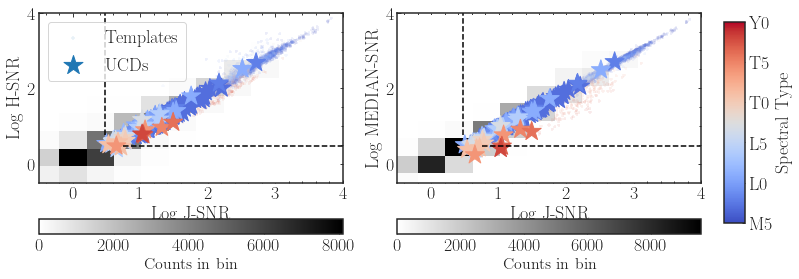

In [54]:
cands_dff=(cands[np.logical_and(cands['snr1'] >=3., cands['spt'] >=17)]).sort_values('spt')
spex_df=spex_df.sort_values('spt')

star_snr=stars[['snr1', 'snr2', 'snr3', 'snr4']].apply(np.log10).dropna()
star_snr=(star_snr[star_snr.snr1.between(-1, 4) & star_snr.snr3.between(-1, 4) & star_snr.snr4.between(-1, 4)]).reset_index(drop=True)


fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(10, 4))

h=ax.hist2d(star_snr['snr1'], star_snr['snr3'], cmap='gist_yarg', bins=10, label='Point Sources')
#ax.scatter(star_snr['snr1'], star_snr['snr3'], c='#111111', s=1, alpha=0.1)
cb = plt.colorbar(h[3], ax=ax, orientation='horizontal')
cb.set_label('Counts in bin', fontsize=16)
plt.tight_layout()

#ax.scatter(star_snr['snr1'],  star_snr['snr4'], s=1., c='k', alpha=0.1, 
#            label='3D-HST or WISP')


ax.scatter(spex_df['snr1'].apply(np.log10), spex_df['snr3'].apply(np.log10),
           marker='+', s=10, c=spex_df.spt, 
            cmap='coolwarm', label='Templates', alpha=0.1, vmin=15, vmax=40) 

ax.scatter(cands_dff['snr1'].apply(np.log10), cands_dff['snr3'].apply(np.log10), 
           c=cands_dff['spt'], s=400,  marker='*', cmap='coolwarm', label='UCDs'
           , vmin=15, vmax=40) 
ax.set_xlim([-0.5, 4])
ax.set_ylim([-0.5, 4])
ax.set_xlabel('Log J-SNR', fontsize=18)
ax.set_ylabel('Log H-SNR', fontsize=18)
ax.legend(fontsize=18, loc='upper left')

ax.axhline(np.log10(3), c='k', xmin=np.log10(3)-0.2, linestyle='--')
ax.axvline(np.log10(3), c='k', ymin=np.log10(3)-0.2, linestyle='--')



#ax1.scatter(stars['snr1'].apply(np.log10), stars['snr4'].apply(np.log10), s=1., c='k', alpha=0.1, 
#            label='3D-HST or WISP')
#ax1.scatter(star_snr['snr1'], star_snr['snr4'], c='#111111', s=1, alpha=0.1)
h1=ax1.hist2d(star_snr['snr1'], star_snr['snr4'], cmap='gist_yarg', bins=10, label='Point Sources')

mp=ax1.scatter(spex_df['snr1'].apply(np.log10), spex_df['snr4'].apply(np.log10), marker='+', s=10, c=spex_df.spt, 
            cmap='coolwarm', label='Templates', alpha=0.1, vmin=15, vmax=40) 

ax1.scatter(cands_dff['snr1'].apply(np.log10), cands_dff['snr4'].apply(np.log10), 
                       c=cands_dff['spt'], s=400, marker='*', cmap='coolwarm', label='UCDs',  vmin=15, vmax=40) 
ax1.set_xlim([-0.5, 4])
ax1.set_ylim([-0.5, 4])
ax1.set_xlabel(' Log J-SNR', fontsize=18)
ax1.set_ylabel('Log MEDIAN-SNR', fontsize=18)
#ax.legend(fontsize=18)

ax1.axhline(np.log10(3), c='k', xmin=np.log10(3)-0.2, linestyle='--')
ax1.axvline(np.log10(3), c='k', ymin=np.log10(3)-0.2, linestyle='--')

cb1 = plt.colorbar(h1[3], ax=ax1, orientation='horizontal')
cb1.set_label('Counts in bin', fontsize=16)
#plt.tight_layout()
import matplotlib
cax = fig.add_axes([1.01, 0.21, .03, 0.7])
norm= matplotlib.colors.Normalize(vmin=15,vmax=40)
mp=matplotlib.cm.ScalarMappable(norm=norm, cmap='coolwarm')
cbar=plt.colorbar(mp, cax=cax, orientation='vertical')
cbar.ax.set_ylabel(r'Spectral Type', fontsize=18)

ax.minorticks_on()
ax1.minorticks_on()

cbar.ax.set_yticks([ 17, 20, 25, 30, 35, 40])
cbar.ax.set_yticklabels(['M5', 'L0', 'L5', 'T0', 'T5', 'Y0'])
plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/snr_cutplots.pdf', bbox_inches='tight', dpi=4000)

In [55]:
#import wisps

In [56]:
big=wisps.get_big_file()
bigsnr=big[big.snr1>=3.]

In [57]:
#

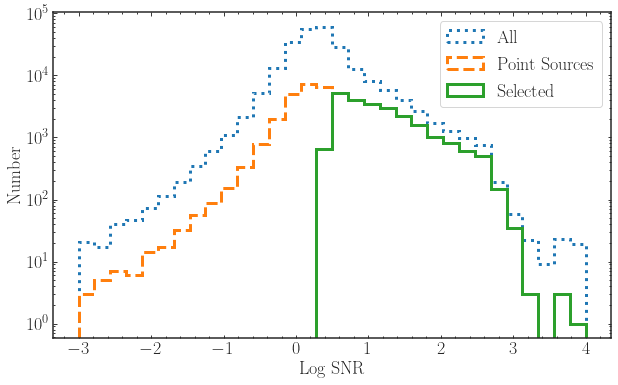

In [75]:
fig, ax=plt.subplots(figsize=(10, 6))
h=ax.hist(big.snr1.apply(np.log10).values, range=[-3, 4], bins=32, histtype='step',  linestyle=':', 
          label='All', log=True, linewidth=3)
h=ax.hist(stars.snr1.apply(np.log10).values, range=[-3, 4], bins=32, histtype='step', linewidth=3, label='Point Sources',
          linestyle='--', log=True)
h=ax.hist(stars[stars.snr1>3].snr1.apply(np.log10).values, range=[-3, 4], bins=32, histtype='step', linewidth=3,
          label='Selected',
          log=True)
#h=ax.hist(bigsnr.snr1.apply(np.log10).values, range=[-3, 4], bins=32, histtype='step', linewidth=3, log=True)
ax.minorticks_on()
plt.xlabel('Log SNR')
plt.ylabel('Number')
plt.legend()
plt.savefig(wisps.OUTPUT_FIGURES+'/snr_distribution.pdf', bbox_inches='tight',  facecolor='white', transparent=False)

In [76]:
#s3=wisps.Source(filename='goodss-01-G141_47749')
s4=wisps.Source(filename='goodss-01-G141_45524')

In [110]:
bools=np.logical_and(stars.snr1.between(3, 1000), stars.f_test.between(1e-3, 1))

In [194]:
s4._best_fit_line

[array([0.05179006, 0.05173844, 0.05168682, 0.05163522, 0.05158358,
        0.05153196, 0.05148033, 0.05142871, 0.05137707, 0.05132542,
        0.0512738 , 0.05122216, 0.05117052, 0.05111885, 0.05106721,
        0.05101556, 0.0509639 , 0.05091223, 0.05086059, 0.05080892,
        0.05075726, 0.05070557, 0.0506539 , 0.05060224, 0.05055055,
        0.05049886, 0.05044718, 0.05039549, 0.0503438 , 0.05029211,
        0.05024042, 0.05018872, 0.05013703, 0.05008532, 0.05003361,
        0.0499819 , 0.04993019, 0.04987848, 0.04982675, 0.04977504,
        0.04972331, 0.0496716 , 0.04961987, 0.04956814, 0.0495164 ,
        0.04946465, 0.04941292, 0.04936117, 0.04930943, 0.04925768,
        0.04920593, 0.04915417, 0.04910242, 0.04905067, 0.04899889,
        0.04894714, 0.04889536, 0.04884359, 0.04879181, 0.04874004,
        0.04868826, 0.04863649, 0.04858469, 0.04853291, 0.04848112,
        0.04842932, 0.04837752, 0.04832572, 0.04827393, 0.04822213,
        0.04817031, 0.04811851, 0.04806669, 0.04

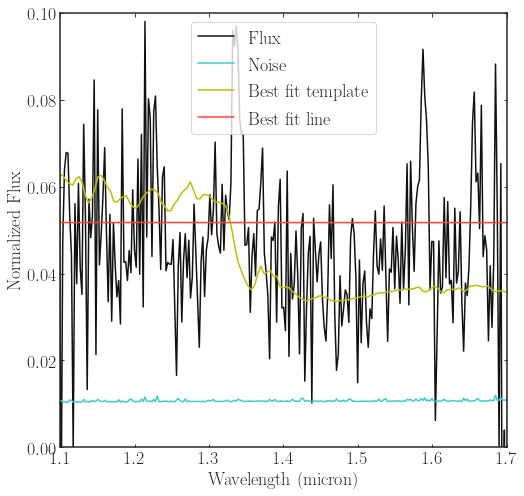

In [205]:
fig, ax=plt.subplots(figsize=(8, 8))
plt.plot(s4.wave, s4.flux, color='#111111', label='Flux')
plt.plot(s4.wave, s4.noise,  '#39CCCC', label='Noise')
std=splat.getStandard(s4.spectral_type[0])
std.normalize(range=[1.2, 1.5])
chi, scale=splat.compareSpectra(s4.splat_spectrum, std,  comprange=[[1.2, 1.5]], statistic='chisqr', scale=True) 
std.scale(scale)
plt.plot(std.wave, std.flux, color='y', label='Best fit template')
plt.plot( s4._best_fit_line[0], color='#FF4136', label='Best fit line')
plt.xlim([1.1, 1.7])
plt.ylim([0, 0.1])
plt.xlabel('Wavelength (micron)')
plt.ylabel('Normalized Flux')
plt.legend()
plt.savefig(wisps.OUTPUT_FIGURES+'/example_line_fit.pdf', bbox_inches='tight',  facecolor='white', transparent=False)

In [129]:
compls.keys()

Index(['L0-L5', 'L5-T0', 'M7-L0', 'T0-T5', 'T5-T9', 'subdwarfs', 'trash',
       'Y dwarfs'],
      dtype='object')

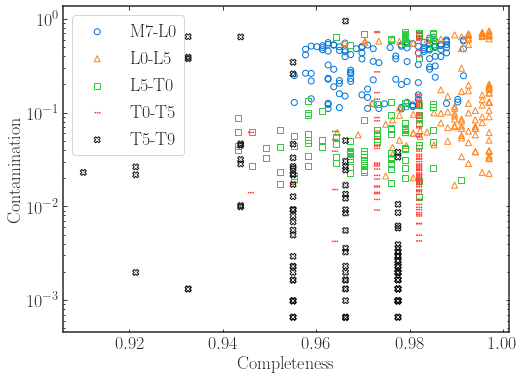

In [164]:
fig, ax=plt.subplots(figsize=(8,6))

#for k in  ['L0-L5', 'L5-T0', 'M7-L0', 'T0-T5', 'T5-T9','subdwarfs']:
ax.scatter(compls['M7-L0'].values, contamns['M7-L0'].values,  facecolors='none', edgecolors='#0074D9', 
           label='M7-L0')
ax.scatter(compls['L0-L5'].values, contamns['L0-L5'].values, marker='^',  facecolors='none',\
           edgecolors='#FF851B', label='L0-L5')

ax.scatter(compls['L5-T0'].values, contamns['L5-T0'].values, marker='s',  facecolors='none',
           edgecolors='#2ECC40', label='L5-T0')

ax.scatter(compls['T0-T5'].values, contamns['T0-T5'].values, marker='$...$',  facecolors='none', 
           edgecolors='#FF4136',
           label='T0-T5')
ax.scatter(compls['T5-T9'].values, contamns['T5-T9'].values, marker='X',  facecolors='none',
           edgecolors='#111111',
           label='T5-T9')
    #h=plt.hist(contams[k].values,  bins='auto', histtype='step',
    #      label='All', log=True, linewidth=3)
ax.set_xlabel('Completeness')
ax.set_ylabel('Contamination')
plt.legend()
ax.set_yscale('log')
plt.savefig(wisps.OUTPUT_FIGURES+'/completeness_contam.pdf', bbox_inches='tight',  facecolor='white', transparent=False)

In [223]:
splat.empirical.typeToTeff('L0.0')

(<Quantity 2233.48 K>, <Quantity 100. K>)